In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import spearmanr, kendalltau
from scipy.sparse import csr_matrix, lil_matrix, hstack, save_npz, load_npz
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

from utils import logit, sigmoid, spearman_kendall

import multiprocessing

DATA_DIR = "/media/elena/13e9efd4-799d-4087-8d03-b4e8eea4a3cc/MADE_DATA/2sem/AdvancedML/chgk/"

In [2]:
try:
    cpu_cnt = multiprocessing.cpu_count()
except NotImplementedError:
    cpu_cnt = 2   # arbitrary default
cpu_cnt

12

> 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
        ◦ взять в тренировочный набор турниры с dateStart из 2019 года; 
        ◦ в тестовый — турниры с dateStart из 2020 года.
        
Данные проанализированы в retrieve_data.ipynb и сохранены в results2019.pkl и results2020.pkl.

In [3]:
with open(DATA_DIR + 'results2019.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(DATA_DIR + 'results2020.pkl', 'rb') as f:
    test_data = pickle.load(f)
type(train_data), len(train_data), len(test_data)

(list, 674, 173)

Данные представляют собой список кортежей (id турнира, список команд). Каждая команда описывается словарем, содержащим: mask - повопросные результаты команды, position - занятое место, players_ids - список id игроков команды.

In [4]:
train_tour_id, train_data = zip(*train_data)
test_tour_id, test_data = zip(*test_data)
train_data[0][:3]

[{'mask': '111111111011111110111111111100010010',
  'position': 1,
  'team_name': 'Рабочее название',
  'questionsTotal': 28,
  'players_ids': [6212, 18332, 18036, 22799, 15456, 26089]},
 {'mask': '111111111011110100101111011001011010',
  'position': 5.5,
  'team_name': 'Сборная Бутана',
  'questionsTotal': 25,
  'players_ids': [1585, 40840, 1584, 10998, 16206]},
 {'mask': '111111111011110101101111001011110000',
  'position': 5.5,
  'team_name': 'Ять',
  'questionsTotal': 25,
  'players_ids': [23513, 18168, 21060, 35850, 31332, 10187]}]


Сделаем предобработку результатов команд. А именно, для каждого турнира найдем матрицу результатов: по строкам - команды, по столбцам - вопросы, соответственно каждый элемент матрицы - ответила ли команда на вопрос. Из этой матрицы уберем те команды, которые не ответили ни на один вопрос, а также те вопросы, на которые не отвелила ни одна команда или ответили все команды, т.к. эти данные не влияют на ранжирование команд.


In [5]:
def tour_preprocess(team_list):
    n_team = len(team_list)
    n_ques = max(len(team['mask']) for team in team_list if team['mask'])
    team_mask = np.zeros((n_team, n_ques))
    for i, team in enumerate(team_list):
        if team['mask'] and team['players_ids']:
            mask = [int(c) if c.isdigit() else 0 for c in team['mask']]
            n = len(mask)
            team_mask[i,:n] = mask[:n]
    team_ans = team_mask.sum(axis=1)
    team_idx = np.where(team_ans != 0)[0]
    
    ques_ans = team_mask.sum(axis=0)
    ques_idx = np.where( (ques_ans > 0) & (ques_ans < n_team) )[0]
    
    team_ans_mtx = team_mask[team_idx,:][:,ques_idx]
    team_player_list = [team['players_ids'] for i, team in enumerate(team_list) if i in team_idx]
    return team_ans_mtx, team_player_list

In [6]:
with multiprocessing.Pool(cpu_cnt) as p:
    train_tour_list = p.map(tour_preprocess, train_data)
#train_tour_list = [tour_preprocess(team_list) for team_list in train_data.values()]
train_tour_list = [(ans_mtx, team_list) 
                   for ans_mtx, team_list in train_tour_list 
                   if ans_mtx.size != 0]
tour_ans_mtx, tour_team_list = zip(*train_tour_list)
del train_tour_list

Подобьем статистику по тренировачным данным.

In [7]:
train_team_cnt = 0
train_ques_cnt = 0
train_player_ques_sample = 0
train_player_freq = defaultdict(int)

for ans_mtx, team_list in zip(tour_ans_mtx, tour_team_list):
    train_team_cnt += ans_mtx.shape[0]
    train_ques_cnt += ans_mtx.shape[1]
    train_player_ques_sample += ans_mtx.shape[1] * \
                              sum(len(team) for team in team_list)
    for team in team_list:
        for player in team:
            train_player_freq[player] += 1
            
(train_player, train_player_freq) = zip(*
                  sorted(train_player_freq.items(),
                  key=lambda x: x[1], reverse=True))
train_player = np.array(list(train_player))
train_player_freq = np.array(list(train_player_freq))
    
print(f'train tours: {len(tour_team_list)}')
print(f'train teams: {train_team_cnt}')
print(f'train questions: {train_ques_cnt}')
print(f'train players: {len(train_player)}')
print(f'train player-ques samples: {train_player_ques_sample}')

train tours: 671
train teams: 86098
train questions: 30719
train players: 58703
train player-ques samples: 25030322


In [8]:
player_to_idx = {
    player : i
    for i, player in enumerate(train_player)
}

>    2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
        ◦ повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
        ◦ в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
        ◦ для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.
        
Пронумеруем всех игроков и все вопросы. Всего у нас 58703 игрока и 30719 вопросов в тренировочных дынных.

Обозначим силу игрока $s_i$, сложность вопроса $v_j$. Тогда можно записать уравнения для логистической регрессии
$$\sigma(s_i + v_j) = r_{ij},$$
где $r_{ij}$ - отвелила ли команда с i-м игроком на j-й вопрос.

Таких уравнений у нас будет 25030322 - столько пар игрок-вопрос мы насчитали выше. Размерности устрашают, но попробуем задать матрицы и рассчитать.

In [9]:
def player_question_encoder():
    n_player = len(train_player)
    n_sample = train_player_ques_sample
    player_mtx = lil_matrix((n_sample, n_player), dtype='uint8')
    ques_mtx = lil_matrix((n_sample, train_ques_cnt), dtype='uint8')
    y_mtx = lil_matrix((n_sample, 1), dtype='uint8')
    
    row = 0
    ques_cnt = 0
    for ans_mtx, team_list in zip(tour_ans_mtx, tour_team_list):
        n_ques = ans_mtx.shape[1]
        nI = np.eye(n_ques)
        for ans, team in zip(ans_mtx, team_list):
            for player in team:
                player_mtx[row : (row + n_ques), player_to_idx[player]] = 1
                y_mtx[row : (row + n_ques)] = ans
                ques_mtx[row : (row + n_ques), 
                         ques_cnt : (ques_cnt + n_ques)] = nI
                row += n_ques
        ques_cnt += n_ques
    print(row, ques_cnt)
    return (player_mtx.tocsr(), 
            ques_mtx.tocsr(),
            y_mtx.tocsr(),
           )

In [10]:
%%time
# player_mtx, ques_mtx, ans_mtx = player_question_encoder()
# save_npz(DATA_DIR + 'player_mtx.npz', player_mtx)
# save_npz(DATA_DIR + 'ques_mtx.npz',   ques_mtx)
# save_npz(DATA_DIR + 'ans_mtx.npz',    ans_mtx)

player_mtx = load_npz(DATA_DIR + 'player_mtx.npz')
ques_mtx = load_npz(DATA_DIR + 'ques_mtx.npz')
ans_mtx = load_npz(DATA_DIR + 'ans_mtx.npz')

CPU times: user 1.26 s, sys: 57.1 ms, total: 1.32 s
Wall time: 1.32 s


Только задать матрицы занимает около 5 мин и больше 10Gb оперативы. Страшно представить как же будет считаться модель)

In [11]:
X_train = hstack([player_mtx, ques_mtx])
y_train = ans_mtx.toarray().ravel()
X_train.shape, y_train.shape

((25030322, 89422), (25030322,))

In [12]:
%%time
# model0 = linear_model.LogisticRegression(C=0.5, solver='liblinear')
# model0.fit(X_train, y_train)

# with open(DATA_DIR + 'player_ques_LR_model.pkl', 'wb') as fout:
#     pickle.dump(model0, fout)
      
with open(DATA_DIR + 'player_ques_LR_model.pkl', 'rb') as f:
    model0 = pickle.load(f)        

CPU times: user 709 µs, sys: 392 µs, total: 1.1 ms
Wall time: 484 µs


Ура, модель посчиталась за пару минут. Посмотрим, какие оказались силы игроков и их распределение.

(array([2293., 5835., 6903., 6902., 7798., 7561., 7342., 6863., 5436.,
        1770.]),
 array([0.03328075, 0.12776411, 0.22224746, 0.31673082, 0.41121417,
        0.50569753, 0.60018088, 0.69466424, 0.78914759, 0.88363095,
        0.9781143 ]),
 <BarContainer object of 10 artists>)

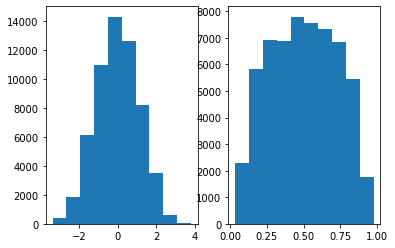

In [13]:
model0_player_logit = model0.coef_[0,:len(player_to_idx)]
model0_player_prob = sigmoid(model0_player_logit)

ax = plt.figure().subplots(1, 2)
ax[0].hist(model0_player_logit)
ax[1].hist(model0_player_prob)

Построим рейтинг игроков и сравним его с официальным рейтингом.

In [14]:
with open(DATA_DIR + 'players.pkl', 'rb') as f:
    players_names = pickle.load(f)

In [15]:
with open(DATA_DIR + 'players-release-2021-04-09.csv') as f:
    player_ofic_rating = [int(row.split(',')[0].strip('"')) 
                          for i, row in enumerate(f)
                          if i > 0]
player_to_ofic_rating = { player_id : i + 1
    for i, player_id in enumerate(player_ofic_rating)}   

In [16]:
def print_player_rating(player_prob, n=10):
    sort_idx = np.argsort(player_prob)[::-1]
    top_names = [f"{i+1, players_names[train_player[idx]]['surname'] if train_player[idx] in players_names else 'no-name'}, "
                 f"tours: {train_player_freq[idx]}, "
                 f"ofic rating: {player_to_ofic_rating[train_player[idx]] if train_player[idx] in player_to_ofic_rating else -1}"
                 for i, idx in enumerate(sort_idx[:n])]
    print('\n'.join(top_names))

In [17]:
print_player_rating(model0_player_prob, 20)

(1, 'Вергизаева'), tours: 1, ofic rating: 9101
(2, 'Боков'), tours: 11, ofic rating: 78
(3, 'Легашов'), tours: 13, ofic rating: 2632
(4, 'Пашковский'), tours: 36, ofic rating: 115
(5, 'Калгин'), tours: 3, ofic rating: 7258
(6, 'Чернин'), tours: 38, ofic rating: 13
(7, 'Эйхгольц'), tours: 6, ofic rating: 3127
(8, 'Степанов'), tours: 27, ofic rating: 43
(9, 'Баранова'), tours: 33, ofic rating: 567
(10, 'Руссо'), tours: 59, ofic rating: 5
(11, 'Петросянц'), tours: 10, ofic rating: 4271
(12, 'Иванцова'), tours: 13, ofic rating: 491
(13, 'Кузьменко'), tours: 18, ofic rating: 89
(14, 'Белоглазов'), tours: 13, ofic rating: 606
(15, 'Сафронов'), tours: 6, ofic rating: 2364
(16, 'Васильев'), tours: 44, ofic rating: 519
(17, 'Заднепровский'), tours: 4, ofic rating: 3997
(18, 'Семушин'), tours: 100, ofic rating: 3
(19, 'Непомнящий'), tours: 6, ofic rating: 7227
(20, 'Берёзкина'), tours: 74, ofic rating: 120


Видно, что полученный рейтинг весьма далек от официального. Рейтинг модели выше у тех, кто сыграл мало турниров.

>     3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
        ◦ предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
        ◦ в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.
        
Чтобы расчитать рейтинг команд по силам игроков, можно суммировать силы n сильнейших игроков команды или посчитать вероятность команды ответить на вопрос: $$ P_{team} = 1 - \Pi_{i=1}^{n} (1 - P(s_i)) $$
        


In [18]:
def team_sum_est(n=3):
    def team_sum_n(player_coef, team_list):
        y_pred = []
        for team in team_list:
            player_idxs = [player_to_idx[player] 
                           for player in team['players_ids']
                           if player in player_to_idx]
            coefs = np.sort(player_coef[player_idxs])[::-1]
            y_pred.append(coefs[:n].sum()
                          if player_idxs else -5)
        y_pred = np.array(y_pred) 
        return y_pred
    return team_sum_n

In [19]:
def team_prob_est(n=3):
    def team_prob_n(player_prob, team_list):
        y_pred = []
        for team in team_list:
            player_idxs = [player_to_idx[player] 
                           for player in team['players_ids']
                           if player in player_to_idx]
            probs = np.sort(player_prob[player_idxs])[::-1]
            inv_probs = 1 - probs
            y_pred.append(1 - inv_probs[:n].prod()
                          if player_idxs else -5)
        y_pred = np.array(y_pred) 
        return y_pred
    return team_prob_n

In [20]:
def print_metric(player_logit, player_prob, n=6):
    print('   sum of logits:')
    print('train: ', 
        spearman_kendall(player_logit, train_data, team_sum_est(n)))
    print('test:  ', 
        spearman_kendall(player_logit, test_data, team_sum_est(n)))
    print('   sum of probs:')
    print('train: ', 
        spearman_kendall(player_prob, train_data, team_sum_est(n)))
    print('test:  ', 
        spearman_kendall(player_prob, test_data, team_sum_est(n)))
    print('   sum of prob squares:')
    print('train: ', 
        spearman_kendall(player_prob**2, train_data, team_sum_est(n)))
    print('test:  ', 
        spearman_kendall(player_prob**2, test_data, team_sum_est(n)))
    print('   team prob:')
    print('train: ', 
        spearman_kendall(player_prob, train_data, team_prob_est(n)))
    print('test:  ', 
        spearman_kendall(player_prob, test_data, team_prob_est(n)))

In [21]:
print_metric(model0_player_logit, model0_player_prob, n=6)

   sum of logits:


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


train:  (0.8215928362609666, 0.6687373076020723)
test:   (0.769228026999463, 0.6083143677159307)
   sum of probs:
train:  (0.7329149979591326, 0.5805693538196333)
test:   (0.6829998641273144, 0.5297687054076927)
   sum of prob squares:
train:  (0.7928233138140955, 0.639097462197701)
test:   (0.744115643930757, 0.5848889492536895)
   team prob:
train:  (0.8014512742644991, 0.6468689194727668)
test:   (0.7554638007932312, 0.5961946310795543)


Слишком сложная получилась модель для бейзлайна. Попробуем ее упростить и посмотреть, как изменится точность.

Для этого посчитаем сначала ретинги команд в каждом турнире. Используем ту же модель: сигма(сила команды + сложность вопроса) = вероятность команды ответить на вопрос. Такие модели построим для каждого турнира.

In [22]:
def tour_team_prob(team_ans_mtx):
    n_team, n_ques = team_ans_mtx.shape
    n_sample = n_team * n_ques
    team_mtx = lil_matrix((n_sample, n_team), dtype='uint8')
    ques_mtx = lil_matrix((n_sample, n_ques), dtype='uint8')
    team_ans = np.zeros(n_sample, dtype='uint8')
    row = 0
    for it in range(n_team):
        team_mtx[row : row + n_ques, it] = 1
        ques_mtx[row : row + n_ques] = np.eye(n_ques)
        team_ans[row : row + n_ques] = team_ans_mtx[it, :]
        row += n_ques
        
    X_train = hstack([team_mtx, ques_mtx]).tocsr()
    y_train = team_ans
    
    model = linear_model.LogisticRegression(C=100, solver='liblinear')
    model.fit(X_train, y_train)

    team_logit = model.coef_[0,:n_team]
    team_prob = sigmoid(team_logit)
    
    team_ratio = team_ans_mtx.sum(axis=1) / n_ques
    return team_prob, team_ratio

Посмотрим, как работает модель для отдельного турнира. Сравним вероятности модели с долей правильных ответов.

(967,) (967,)


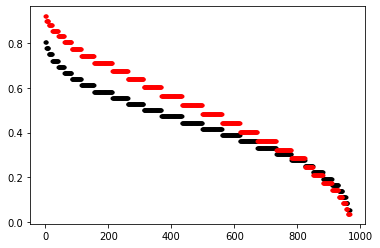

In [23]:
team_prob, team_ratio = tour_team_prob(tour_ans_mtx[3])

print(team_prob.shape, team_ratio.shape)

plt.figure()
plt.plot(team_ratio, 'k.')
plt.plot(team_prob, 'r.')

In [24]:
%%time
with multiprocessing.Pool(cpu_cnt) as p:
    tour_ans_prob, _ = zip(*p.map(tour_team_prob, tour_ans_mtx))
#tour_ans_prob = [tour_team_prob(team_ans)[0] for team_ans in tour_ans_mtx]

for team_ans in tour_ans_prob:
    team_ans[team_ans < 0.001] = 0.001
    team_ans[team_ans > 0.999] = 0.999    

CPU times: user 281 ms, sys: 160 ms, total: 441 ms
Wall time: 13.3 s


In [25]:
len(tour_ans_prob)

671

671 модель просчиталась довольно быстро. Теперь, зная вероятности команд в каждом турнире, построим линейную модель для каждого игрока:
сигма(сила игрока + сложность турнира) = вероятность команды ответить.

In [26]:
def player_tour_encoder(tour_team_list, tour_ans_prob, player_to_idx):
    n_player = len(player_to_idx)
    n_tour = len(tour_team_list)
    n_sample = sum(len(team)
                   for team_list in tour_team_list
                   for team in team_list)
    
    player_mtx = lil_matrix((n_sample, n_player), dtype='uint8')
    tour_mtx = lil_matrix((n_sample, n_tour), dtype='uint8')
    team_prob_arr = np.zeros(n_sample, dtype='float')
    
    row = 0
    for i_tour, (team_list, team_ans) in enumerate(zip(tour_team_list, tour_ans_prob)):
        for team, ans in zip(team_list, team_ans):
            team_size = len(team)
            team_prob_arr[row : row + team_size] = ans
            tour_mtx[row : row + team_size, i_tour] = 1
            for ip, player in enumerate(team):
                player_mtx[row + ip, player_to_idx[player]] = 1
            row += team_size
            
    return (player_mtx.tocsr(), 
            tour_mtx.tocsr(),
            team_prob_arr,
           )    

In [27]:
%%time
player_mtx, tour_mtx, team_prob_arr = player_tour_encoder(tour_team_list, tour_ans_prob, player_to_idx)
player_mtx.shape, tour_mtx.shape, team_prob_arr.shape

CPU times: user 8.16 s, sys: 197 ms, total: 8.36 s
Wall time: 8.26 s


((450304, 58703), (450304, 671), (450304,))

In [28]:
X_train = hstack([player_mtx, tour_mtx])
y_train = logit(team_prob_arr)

(array([3058., 5978., 6323., 6374., 7079., 7223., 7136., 6974., 5980.,
        2578.]),
 array([0.01474273, 0.1119351 , 0.20912747, 0.30631985, 0.40351222,
        0.5007046 , 0.59789697, 0.69508935, 0.79228172, 0.8894741 ,
        0.98666647]),
 <BarContainer object of 10 artists>)

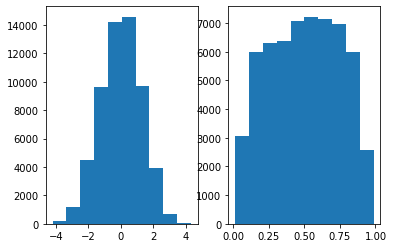

In [29]:
model = linear_model.Ridge(alpha=0.3)
model.fit(X_train, y_train)
player_logit = model.coef_[:len(player_to_idx)]
player_prob = sigmoid(player_logit)

ax = plt.figure().subplots(1, 2)
ax[0].hist(player_logit)
ax[1].hist(player_prob)

In [30]:
print_player_rating(player_prob, 20)

(1, 'Руссо'), tours: 59, ofic rating: 5
(2, 'Семушин'), tours: 100, ofic rating: 3
(3, 'Брутер'), tours: 72, ofic rating: 6
(4, 'Савченков'), tours: 85, ofic rating: 2
(5, 'Спешков'), tours: 93, ofic rating: 4
(6, 'Сорожкин'), tours: 130, ofic rating: 1
(7, 'Чернин'), tours: 38, ofic rating: 13
(8, 'Мереминский'), tours: 39, ofic rating: 38
(9, 'Саксонов'), tours: 33, ofic rating: 158
(10, 'Николенко'), tours: 50, ofic rating: 10
(11, 'Пашковский'), tours: 36, ofic rating: 115
(12, 'Левандовский'), tours: 34, ofic rating: 8
(13, 'Прокофьева'), tours: 27, ofic rating: 65
(14, 'Либер'), tours: 95, ofic rating: 7
(15, 'Коврижных'), tours: 71, ofic rating: 104
(16, 'Степанов'), tours: 27, ofic rating: 43
(17, 'Гилёв'), tours: 115, ofic rating: 30
(18, 'Вергизаева'), tours: 1, ofic rating: 9101
(19, 'Новиков'), tours: 35, ofic rating: 132
(20, 'Горелова'), tours: 52, ofic rating: 349


Рейтинг игроков намного ближе к официальному. Однако он сильно зависит от регуляризации - коэффициента альфа. Если регуляризации нет

In [31]:
model = linear_model.Ridge(alpha=0)
model.fit(X_train, y_train)
player_logit = model.coef_[:len(player_to_idx)]
player_prob = sigmoid(player_logit)
print_player_rating(player_prob, 20)

(1, 'Вергизаева'), tours: 1, ofic rating: 9101
(2, 'Руссо'), tours: 59, ofic rating: 5
(3, 'Семушин'), tours: 100, ofic rating: 3
(4, 'Брутер'), tours: 72, ofic rating: 6
(5, 'Кудинов'), tours: 1, ofic rating: -1
(6, 'Савченков'), tours: 85, ofic rating: 2
(7, 'Спешков'), tours: 93, ofic rating: 4
(8, 'Резникова'), tours: 3, ofic rating: 5828
(9, 'Сорожкин'), tours: 130, ofic rating: 1
(10, 'Калгин'), tours: 3, ofic rating: 7258
(11, 'Людикайнен'), tours: 4, ofic rating: 3445
(12, 'Пилипенко'), tours: 1, ofic rating: 9969
(13, 'Чернин'), tours: 38, ofic rating: 13
(14, 'Мереминский'), tours: 39, ofic rating: 38
(15, 'Саксонов'), tours: 33, ofic rating: 158
(16, 'Пашковский'), tours: 36, ofic rating: 115
(17, 'Николенко'), tours: 50, ofic rating: 10
(18, 'Левандовский'), tours: 34, ofic rating: 8
(19, 'Эйхгольц'), tours: 6, ofic rating: 3127
(20, 'Подюкова'), tours: 1, ofic rating: -1


Получаем опять в топе людей, которые сыграли всего несколько турниров.
Посмотрим на метрики для команд:

In [32]:
print_metric(player_logit, player_prob, 6)

   sum of logits:


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


train:  (0.8400283373840852, 0.6919592330285232)
test:   (0.7854787095799937, 0.628348955067075)
   sum of probs:
train:  (0.739603760304034, 0.5936668563690845)
test:   (0.6990851552832064, 0.5457856581398907)
   sum of prob squares:
train:  (0.7983845393392828, 0.6488181921065181)
test:   (0.751558782536371, 0.5944791942053183)
   team prob:
train:  (0.8276507747757493, 0.6779880908867557)
test:   (0.7820748236807341, 0.625906843114901)


Метрики тоже улучшились. Странно, то ли действительно более простая модель лучше описывает данные, либо в сложной модели баг..

>     4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
        ◦ предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
        ◦ разработайте EM-схему для обучения этой модели, реализуйте её в коде;
        ◦ обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.
        
Текущая модель: сигма(сила игрока + сложность турнира) = вероятность команды ответить. Видно, что правая часть не соответствует левой: мы приписываем результат всей команды каждому ее игроку.
Введем скрытые переменные - то, что должно быть в правой части модели. А именно - вероятность игрока ответить в данном турнире. 

ЕМ-схема будет работать следующим образом: Е-шаг: считаем левую часть по имеющейся модели, т.е. предсказываем правую. Корректируем посчитанные значения исходя из командных вероятностей. М-шаг: просчитываем модель по откорректированным правым вероятностям.

In [33]:
def E_step(model):
    y_pred_logit = model.predict(X_train)
    y_pred_prob = sigmoid(y_pred_logit)
    
    player_tour_prob = np.zeros_like(y_train)

    row = 0
    for team_list, tour_ans in zip(tour_team_list, tour_ans_prob):
        for team, team_ans in zip(team_list, tour_ans):
            team_size = len(team)
            player_prob = y_pred_prob[row : row + team_size]
            team_prob = 1 - (1 - player_prob).prod()
            
            assert player_tour_prob[row : row + team_size].sum() == 0
            player_tour_prob[row : row + team_size] = player_prob / team_prob * team_ans
            row += team_size 
    return player_tour_prob

def M_step(player_tour_prob):
    model = linear_model.Ridge(alpha=0.3)
    model.fit(X_train, logit(player_tour_prob))
    return model

In [34]:
model = linear_model.Ridge(alpha=0.3)
model.fit(X_train, y_train)

for i in range(10):
    player_logit = model.coef_[:len(player_to_idx)]
    player_prob = sigmoid(player_logit)

    print(f'step: {i}')
    print('   train: ', 
        spearman_kendall(player_prob, train_data, team_prob_est(6)))
    print('   test: ', 
        spearman_kendall(player_prob, test_data, team_prob_est(6)))

    player_tour_prob = E_step(model)
    model = M_step(player_tour_prob)

step: 0


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8263204386784653, 0.6754066278063081)
   test:  (0.7802092491088617, 0.6228164247006643)
step: 1


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8338179948160693, 0.6839396047228168)
   test:  (0.7855281893684491, 0.6278172250519467)
step: 2


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8407499290433922, 0.6930005102357226)
   test:  (0.7878807557106874, 0.6305146343735927)
step: 3


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8460721723599965, 0.6997390951831052)
   test:  (0.7880840994109902, 0.6296532572963103)
step: 4


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8485440256927441, 0.7028472417670132)
   test:  (0.7842293954391943, 0.6261788538128326)
step: 5


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8493746438397548, 0.7042801357462569)
   test:  (0.7822819981924434, 0.6244773461703178)
step: 6


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8502724228515144, 0.7054798314581779)
   test:  (0.7803628261297736, 0.6226645903364476)
step: 7


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8510376473327773, 0.7064115565718321)
   test:  (0.7787782222629236, 0.6208165866319906)
step: 8


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8519069404912044, 0.7074203601902658)
   test:  (0.777903490064944, 0.6197998225425108)
step: 9


/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8525633409617248, 0.7079217305323885)
   test:  (0.7776997393352278, 0.6196219912093337)


Из результатов итераций видно, что на тренировочных данных метрики улучшаются с каждым шагом. А на тестовых метрики увеличиваются только после первых двух итераций. Выберем лучшую тестовую модель: 

In [35]:
model = linear_model.Ridge(alpha=0.3)
model.fit(X_train, y_train)
for i in range(2):
    player_tour_prob = E_step(model)
    model = M_step(player_tour_prob)
    
player_logit = model.coef_[:len(player_to_idx)]
player_prob = sigmoid(player_logit)

print('   train: ', 
    spearman_kendall(player_prob, train_data, team_prob_est(6)))
print('   test: ', 
    spearman_kendall(player_prob, test_data, team_prob_est(6)))

/home/elena/MADE/made_env385/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


   train:  (0.8407499290433922, 0.6930005102357226)
   test:  (0.7878807557106874, 0.6305146343735927)


(array([2914., 5686., 6534., 6686., 7376., 7522., 7128., 6381., 5478.,
        2998.]),
 array([0.00805226, 0.10644527, 0.20483828, 0.30323128, 0.40162429,
        0.5000173 , 0.59841031, 0.69680332, 0.79519633, 0.89358933,
        0.99198234]),
 <BarContainer object of 10 artists>)

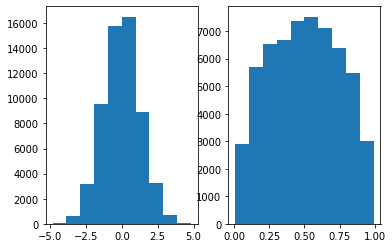

In [36]:
ax = plt.figure().subplots(1, 2)
ax[0].hist(player_logit)
ax[1].hist(player_prob)

In [37]:
print_player_rating(player_prob, 20)

(1, 'Руссо'), tours: 59, ofic rating: 5
(2, 'Семушин'), tours: 100, ofic rating: 3
(3, 'Брутер'), tours: 72, ofic rating: 6
(4, 'Савченков'), tours: 85, ofic rating: 2
(5, 'Спешков'), tours: 93, ofic rating: 4
(6, 'Сорожкин'), tours: 130, ofic rating: 1
(7, 'Чернин'), tours: 38, ofic rating: 13
(8, 'Николенко'), tours: 50, ofic rating: 10
(9, 'Левандовский'), tours: 34, ofic rating: 8
(10, 'Пашковский'), tours: 36, ofic rating: 115
(11, 'Прокофьева'), tours: 27, ofic rating: 65
(12, 'Мереминский'), tours: 39, ofic rating: 38
(13, 'Саксонов'), tours: 33, ofic rating: 158
(14, 'Либер'), tours: 95, ofic rating: 7
(15, 'Гилёв'), tours: 115, ofic rating: 30
(16, 'Коврижных'), tours: 71, ofic rating: 104
(17, 'Степанов'), tours: 27, ofic rating: 43
(18, 'Новиков'), tours: 35, ofic rating: 132
(19, 'Царёв'), tours: 12, ofic rating: 311
(20, 'Мокин'), tours: 30, ofic rating: 74


Теперь посмотрим, как можно получить максимальные метрики для команд

In [38]:
print_metric(player_logit, player_prob, 3)

   sum of logits:
train:  (0.8486784665164452, 0.7009875832031343)
test:   (0.8004411866410098, 0.6427161088062152)
   sum of probs:
train:  (0.8432037372163629, 0.6968471130752303)
test:   (0.7949279681400939, 0.6389882166967927)
   sum of prob squares:
train:  (0.8481866133147565, 0.7014140462067625)
test:   (0.8010809746536702, 0.6450730298554439)
   team prob:
train:  (0.8487862139927072, 0.7020755039759692)
test:   (0.8021459065585256, 0.6456093721027387)


Экспериментально можно определить, что максимальные метрики для команды получаются, если считать командные результат по 3-4 лучшим ее игрокам.